This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    20404
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      100

Total number of variables............................:      302
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      100
                     variables with only upper bounds:        0
Total number of equality constraints.................:      204
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  


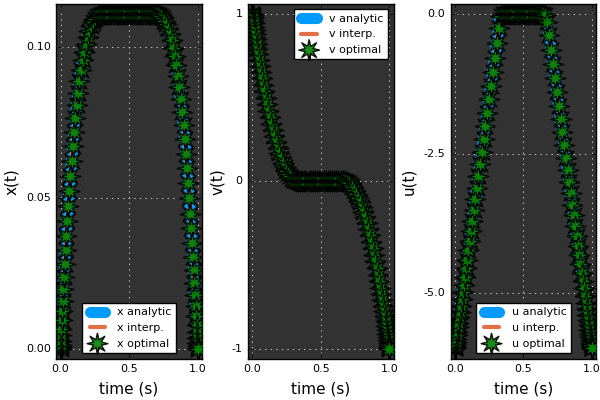

/home/febbo/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'Helvetica'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [3]:
using NLOptControl
using JuMP
using Ipopt
using Parameters
using Plots
#using VehicleModels
pyplot()

##################################
# Define NLOptControl problem
##################################

# user defined dynamic constraint equations
function stateEquations(x_int::Array{Any,2},u_int::Array{Any,2},st::Int64)
  if st==1
    return x_int[1:end-1,2] # state eq# 1; v(t)
  elseif st==2
    return u_int[:,1]       # state eq# 2; u(t)
  end
end

L = 1/9;
X0=[0.;1]; XF=[0.;-1.] #TODO check to see what form this should be in ; or ,
                       #TODO allow for int inputs and just convert them to Float64
XL=[0.,-Inf]; XU=[L,Inf]; # TODO allow for functions of these so we can calculate them on the fly!
CL=[-Inf]; CU=[Inf];
t0 = Float64(0); tf = Float64(1);
ps, nlp = initialize_NLP(t0,tf,numStates=2,
                         numControls=1,
                         Ni=1,Nck=[100],
                         stateEquations=stateEquations,
                         X0=X0,XF=XF,XL=XL,XU=XU,CL=CL,CU=CU;
                         (:finalTimeDV => false));

##################################
# Define JuMP problem
##################################

mdl = Model(solver = IpoptSolver());

x,u=OCPdef(mdl,nlp,ps)

obj = integrate(mdl,ps,u[:,1];C=0.5,(:variable=>:control),(:integrand=>:squared))

@NLobjective(mdl, Min, obj)

obj_val = solve(mdl)

tol = 10e-3;
if abs(getvalue(obj) - 4/(9*L)) < tol
  print("\n Solution is correct to tolerance specs.!! \n \n")
else
  print(string("\n",
                "-------------------------------------", "\n",
                "The solution is not correct!!", "\n",
                "-------------------------------------", "\n",
                "The following values should be equal:", "\n",
                "4/(9*L)= ",4/(9*L),"\n",
                "getvalue(obj) = ",getvalue(obj),"\n"
                )
        )
end

####################################
## analytic soltion when 0<=L<=1/6
###################################
# analytic soltion for:    0 <= t <= 3L
u1(t) = -2/(3*L)*(1-t/(3*L));
v1(t) = (1 - t/(3*L))^2;
x1(t) = L*(1 - (1 - t/(3*L))^3 );

# analytic soltion for:   3L <= t <= 1-3L
u2(t) = 0;
v2(t) = 0;
x2(t) = L;

# analytic soltion for: 1-3L <= t <= 1
u3(t) = -2/(3*L)*(1 - (1-t)/(3*L) )
v3(t) = -(1 - (1-t)/(3*L) )^2
x3(t) =  L*(1 - (1 - (1-t)/(3*L) )^3 );

@unpack lengthStateVector = nlp
@unpack t0, tf = ps
pts = 100;
t = linspace(t0,tf,pts)
x_analytic = zeros(Float64,pts,);
v_analytic = zeros(Float64,pts,);
u_analytic = zeros(Float64,pts,);

for i in 1:pts
  if L > 1/6
    warn("\n analytical solution only valid for L < 1/6!! \n")
  end

  if t[i] < 3*L
    u_analytic[i]=u1(t[i]);
    v_analytic[i]=v1(t[i]);
    x_analytic[i]=x1(t[i]);
  elseif ((3*L <= t[i]) && (t[i] <= (1-3*L)))
    u_analytic[i]=u2(t[i]);
    v_analytic[i]=v2(t[i]);
    x_analytic[i]=x2(t[i]);
  elseif (((1-3*L) <= t[i]) && (t[i] <= 1))
    u_analytic[i]=u3(t[i]);
    v_analytic[i]=v3(t[i]);
    x_analytic[i]=x3(t[i]);
  else
    error(" \n Not setup for outside of this range \n
                TRY: t0 = 0. and tf = 1. \n")
  end
end

##################################
# Post Processing
##################################
# visualize solution
@unpack ts = ps
lw=8; lw2=3;
t_ctr= [idx for tempM in ts for idx = tempM[1:end-1]];
t_st = append!(t_ctr,ts[end][end]);

p1=plot(t,x_analytic, label = "x analytic",w=lw)
plot!(t_st,getvalue(x[:,1]), label = "x interp.",w=lw2)
scatter!(t_st,getvalue(x[:,1]), label = "x optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("x(t)")
xlabel!("time (s)")

p2=plot(t,v_analytic, label = "v analytic",w=lw)
plot!(t_st,getvalue(x[:,2]), label = "v interp.",w=lw2)
scatter!(t_st,getvalue(x[:,2]), label = "v optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("v(t)")
xlabel!("time (s)")

p3=plot(t,u_analytic, label = "u analytic",w=lw)
plot!(t_ctr,getvalue(u[:,1]), label = "u interp.",w=lw2)
scatter!(t_ctr,getvalue(u[:,1]), label = "u optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("u(t)")
xlabel!("time (s)")

plot(p1,p2,p3,layout=(1,3),background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))


#=TODO stuff
# TODO let the user define the objective function above
# TODO allow user to select from using the IMatrix or quadrature
=#


In [1]:
solve(mdl)

LoadError: UndefVarError: solve not defined

In [3]:
# resize to save
xlims!(t0,tf*1.1)
plot!(titlefont=font(14),guidefont=font(14),tickfont=font(12),legendfont=font(12))
plot!(leg=:best)
plot!(size=(700,850))
savefig("test1a.png")

In [4]:
using VehicleModels
spline_U = Linear_Spline(t_ctr,getvalue(u));
p3=plot(t,u_analytic, label = "u analytic",w=lw)
scatter!(t,spline_U[t], label = "u interp.",w=lw2)
scatter!(t_ctr,getvalue(u), label = "u optimal",marker = (:star8, 15, 0.9, :green))
ylabel!("u(t)")
xlabel!("time (s)")
plot(p3,background_color_subplot=RGB(0.2,0.2,0.2), background_color_legend=RGB(1,1,1))
plot!(foreground_color_grid=RGB(1,1,1))

LoadError: MethodError: no method matching Linear_Spline(::Array{Float64,1}, ::Array{Float64,2})
Closest candidates are:
  Linear_Spline(::Array{T,1}, !Matched::Array{T,1}) at /home/febbo/.julia/v0.5/VehicleModels/src/utils.jl:6